# Intro

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy
import io

%load_ext autoreload
%autoreload 2

In [2]:
fm = FileManager()
preprocessing_config = fm.load_json('preprocessing-config.txt')

In [3]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [4]:
SEED = preprocessing_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [6]:
labels = labeled_with_target[['status_group']]

In [7]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [8]:
classes = list(let_labels.labelencoder.classes_)

In [9]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [10]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [12]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [13]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [14]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [15]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [16]:
cartesian_prod = 1
brute_force_complexity = []
n_exp = 0
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = preprocessing_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        n_exp += 1
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity}) \\in O(n^" + "{" + f"{n_exp}" + "})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"In our case, this would amount to {cartesian_prod} iterations doing it the brute-force way!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |amount_tsh|\times |source|\times |source_type|\times |source_class|\times |quantity|\times |quantity_group|\times |water_quality|\times |quality_group|\times |gps_height|\times |gps_coordinates|\times |waterpoint_type|\times |waterpoint_type_group|\times |installer|\times |population|\times |geographic_location|\times |subvillage|\times |wpt_operator|\times |pump_age|\times |payment_type|\times |payment|\times |num_private|\times |wpt_name|\times |basin|\times |public_meeting|\times |recorded_by|\times |permit|\times |management|\times |management_group|\times |funder|) \in O(n^{32})$

In our case, this would amount to 710280216576 iterations doing it the brute-force way!)

You read that correctly: if we do this using brute-force, that would require building (transforming) a virtually uncountable number of data sets.

That is obviously intractible.  

Consider the case when transforming and building a model on X_train and predicting on X_validation takes, on average, 1 minute.

There are 525600 minutes in one year.

In [17]:
display(HTML(f"Doing it the brute-force way (the space of all possible combinations of preprocessing options) would require about {int((cartesian_prod/525600)/100)} CENTURIES!!! LOL!"))

Instead, we will use a Greedy Algorithm to turn this into a linear problem.

## Baselining the Greedy Way - Another Exercise in Dynamic Programming

The idea goes like this:

1. Build a baseline model using the most features possible - since a lot of features contains `nan` values, this precludes the use of `DecisionTreeClassifier` and `RandomForestClassifier` for baselining; thus, we will baseline using `XGBClassifier` since it allows `nan`s.
2. From there, we will try out each option for each feature-group (specified in the config) - to be clear, we will include the baseline features plus those involved in the particular preprocessing option.
3. Build a model (with `XGBClassifier`) and compare its validation accuracy to the validation accuracy of the baseline model - if it goes down or stays the same, this obviously is not a good preprocessing option to keep; if it goes up from the baseline, then we will obviously keep this preprocessing option; we will keep the option that garners the best improvement on a per-feature-group basis.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [18]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = sorted(list(X_train_baseline.columns))
baseline_cols

['amount_tsh',
 'construction_year',
 'district_code',
 'gps_height',
 'latitude',
 'longitude',
 'num_private',
 'population',
 'region_code']

In [19]:
X_train_baseline = X_train_baseline[baseline_cols]
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [20]:
X_validation_baseline = X_validation[baseline_cols]

In [21]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [22]:
clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

### Iterate each preprocessing option (from config file), apply, compare results to Baseline - Keep the options that increase accuracy over Baseline

In [23]:
# the key, the heart of the algo...
def find_best_option(feature_group_name, preprocessing_group_name, best_options, y_acc):
    display(HTML(f"<h2 style='background-color: yellow;'>Finding best option for feature group <i>{feature_group_name}</i>, preprocessing group <i><font color='red'>{preprocessing_group_name}</font></i> after baseline...</h2>"))

    best = None
    preprocessing__group_options = preprocessing_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)
    
    cols_prior = []
    
    _y_acc = []

    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h3 style='background-color: yellow;'>Transforming X with PRIOR best options...</h3>"))
        
        # include (best) results found previously
        for prior_best_option in best_options:
            composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors
            )
            scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_train_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
            transformed_cols = set(transformed_cols)
            
            # filter out any columns that were dropped
            filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), baseline_cols)))
            display(HTML(f"<h4>baseline features in X after this transformation:</h4>"))
            display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
            
            # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
            cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
            prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
            # now we need to filter out the ones not in X
            filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), filtered_transformed_feat_names)))
            filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
            display(HTML(f"<h4>features (not in baseline) in X after transformation (including best priors):</h4>"))
            display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
            
            baseline_plus_transformed_cols = filtered_baseline_cols
            if len(filtered_transformed_feat_names) > 0:
                baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)
                
            cols_prior = baseline_plus_transformed_cols
            display(HTML(f"<h4>features included from prior best modes:</h4>"))
            buffer = io.StringIO()
            X_train_priors_transformed[cols_prior].info(buf=buffer)
            s_info = buffer.getvalue()
            display(HTML(f"<pre>{s_info}</pre>"))
            
        display(HTML(f"<h4>terminal features in prior best model:</h4>"))
        buffer = io.StringIO()
        X_train_priors_transformed[cols_prior].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))
    
    # iterate through options to find best result
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = []

        display(HTML(f"<h3 style='background-color: yellow;'>Transforming X with option {idx+1}:</h3>"))
        composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
            preprocessing_option, 
            preprocessing_group_name,
            pipeline_temp
        )
        scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
        X_train_transformed = composite_transformer.fit_transform(X_train_priors_transformed.copy(), y_train_encoded.status_group)
        
        # get list of cols transformed by this option
        transformed_cols = []
        scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
        transformed_cols = set(transformed_cols)
        
        # filter out any columns that were dropped
        filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), baseline_cols)))
        display(HTML(f"<h4>baseline features in X after this transformation:</h4>"))
        display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
        
        # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
        cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
        prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
        # now we need to filter out the ones not in X
        filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), filtered_transformed_feat_names)))
        filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
        display(HTML(f"<h4>features (not in baseline) in X after transformation (including best priors):</h4>"))
        display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
        
        baseline_plus_transformed_cols = filtered_baseline_cols
        if len(filtered_transformed_feat_names) > 0:
            baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)

        cols_in_model.extend(baseline_plus_transformed_cols)
        display(HTML(f"<h4>features to be included in model:</h4>"))
        buffer = io.StringIO()
        X_train_transformed[cols_in_model].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))

        if len(cols_in_model) > 0:
            display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            display(HTML(f"<h4>Transforming validation set with current option...</h4>"))
            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]

            display(HTML(f"<h4>Using model to predict y's on validation set...</h4>"))
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            
            _y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[3]:
                best = (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
                display(HTML(f"<h4 style='background-color: yellow;'><i>Option {idx+1}</i> yields new BEST-IN-GROUP validation accuracy.</h4>"))
        else:
            display(HTML(f"<h4><font color='red'>COULD NOT BUILD MODEL AS THERE ARE NO FEATURES TO BE INCLUDED!</font></h4>"))
        
        
        display(HTML("<p><br><br><br><br>"))
        
    y_acc.append({'ppgn': preprocessing_group_name, 'acc': _y_acc})

    if best[3] <= _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>NO OPTION INCREASES ACCURACY ABOVE BASELINE ({_accuracy_validation_baseline})!</font></h2>"))
    else:
        display(HTML(f"<h2><font color='green'>Best option increases accuracy to {best[3]} ABOVE BASELINE ({_accuracy_validation_baseline}):</font></h2>"))
        display(HTML(f"<pre>{(best[0], best[1], best[3])}</pre>"))

    return best, y_acc

In [24]:
# # test out individual preprocessing groups here, for example...
best_options = []
y_acc = []
# find_best_option('installer__group', 'installer', best_options, y_acc)
# find_best_option('funder__group', 'funder', best_options, y_acc)
# find_best_option('pump_age_at_observation_date__group', 'pump_age', best_options, y_acc)
# find_best_option('geographic_location__group', 'subvillage', best_options, y_acc)
# find_best_option('num_private__group', 'num_private', best_options, y_acc)
# find_best_option('wpt_operator__group', 'wpt_operator', best_options, y_acc)
# find_best_option('gps_coordinates__group', 'gps_coordinates', best_options, y_acc)

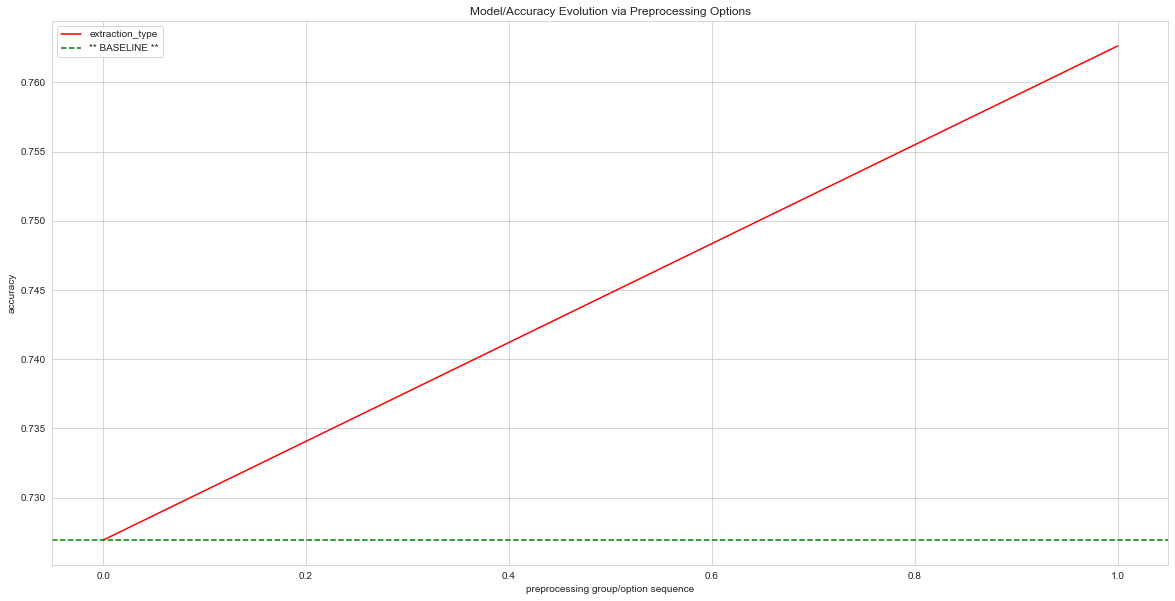

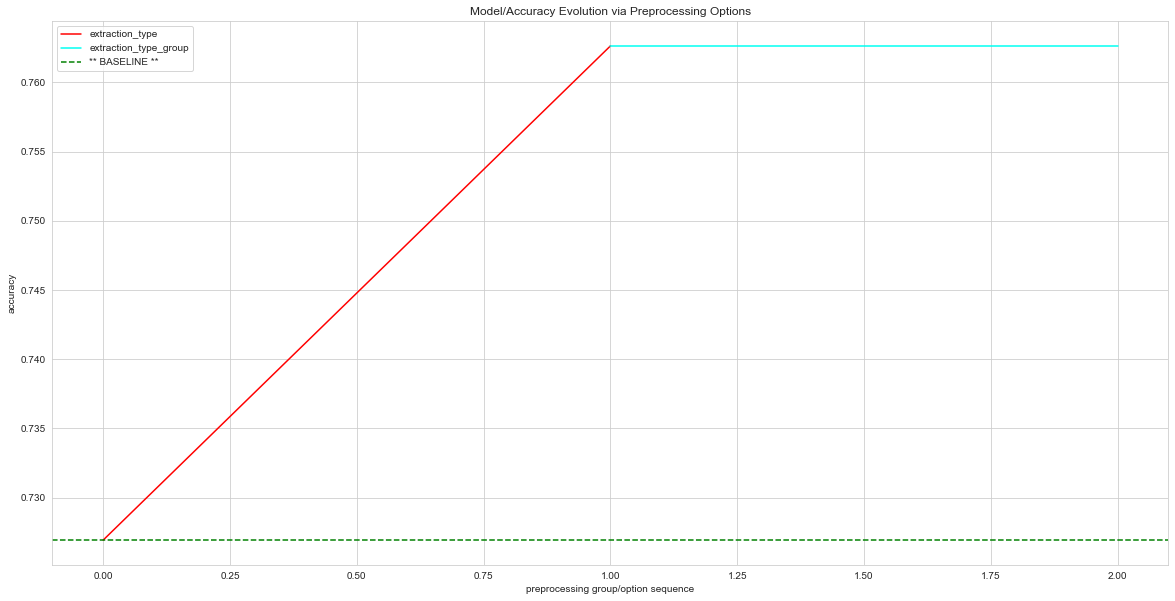

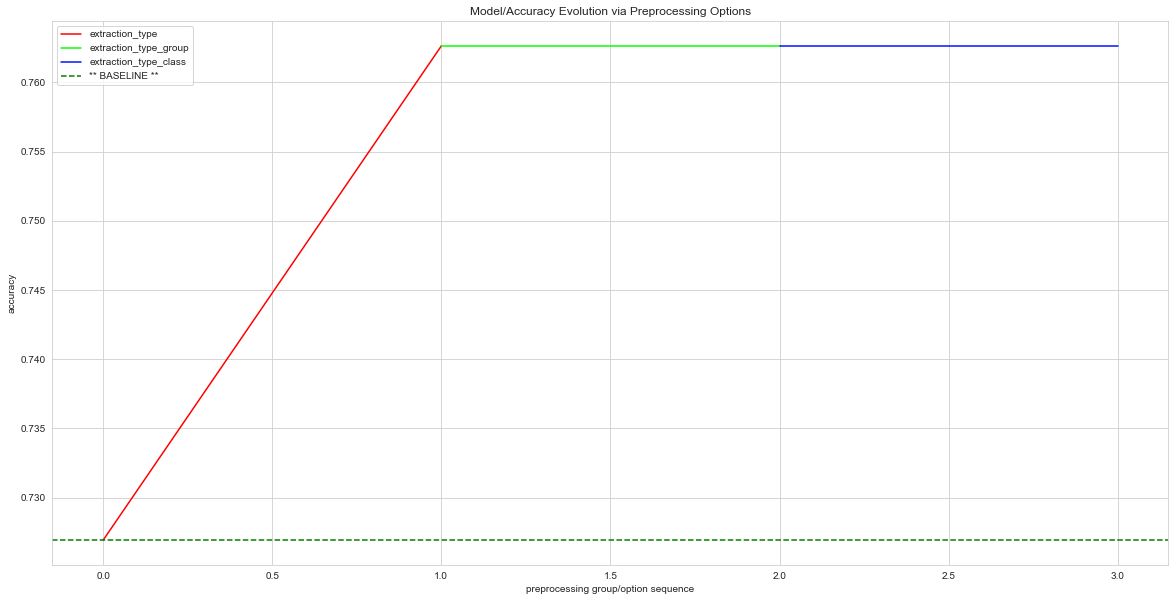

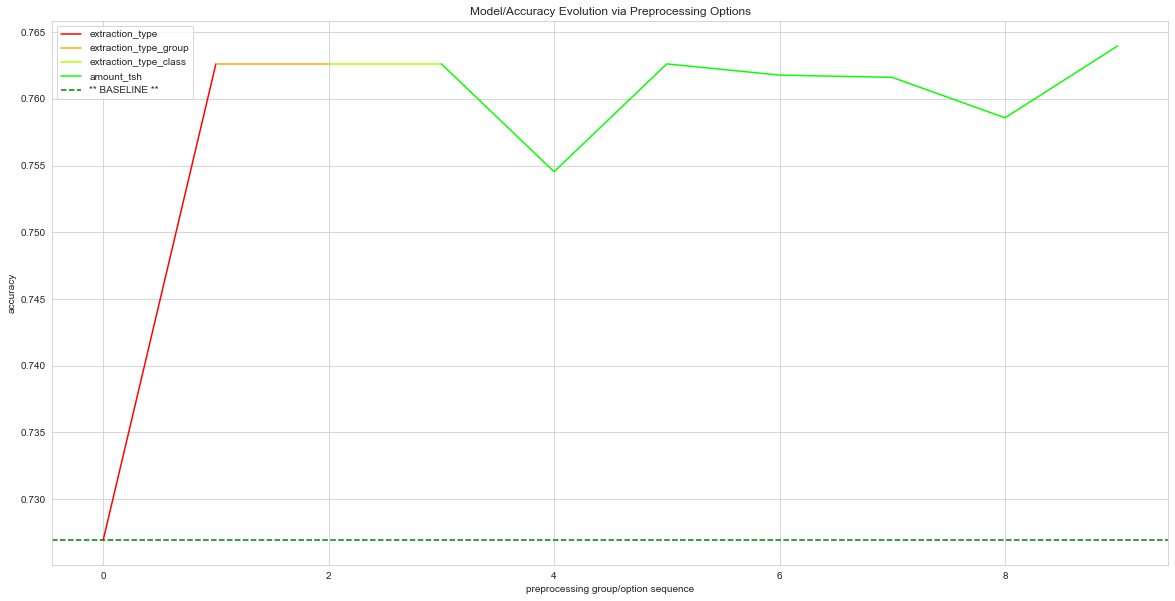

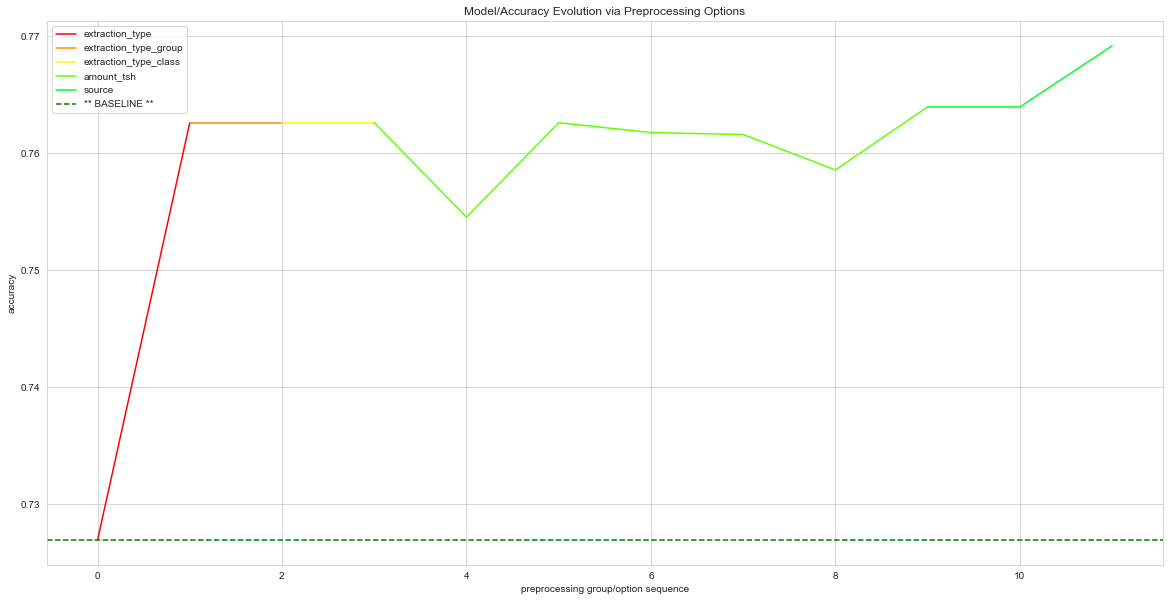

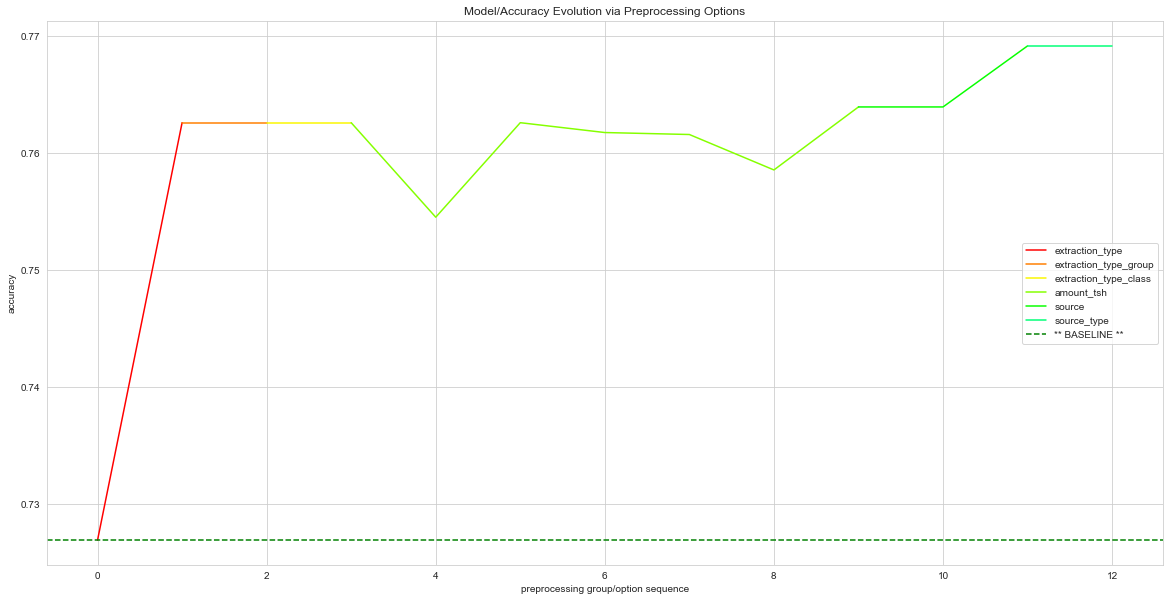

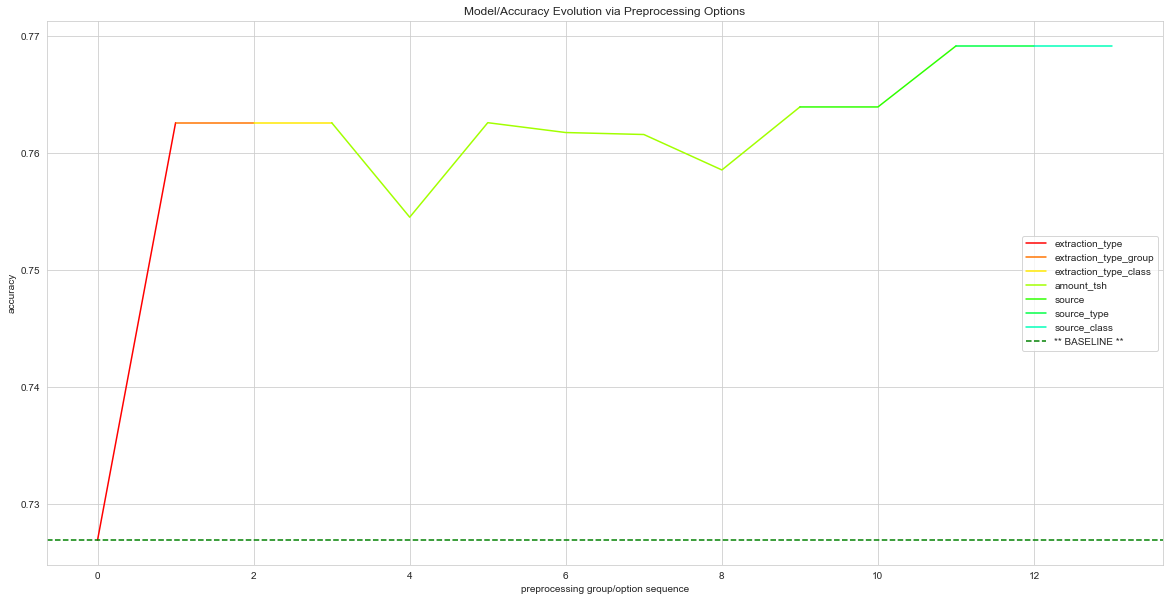

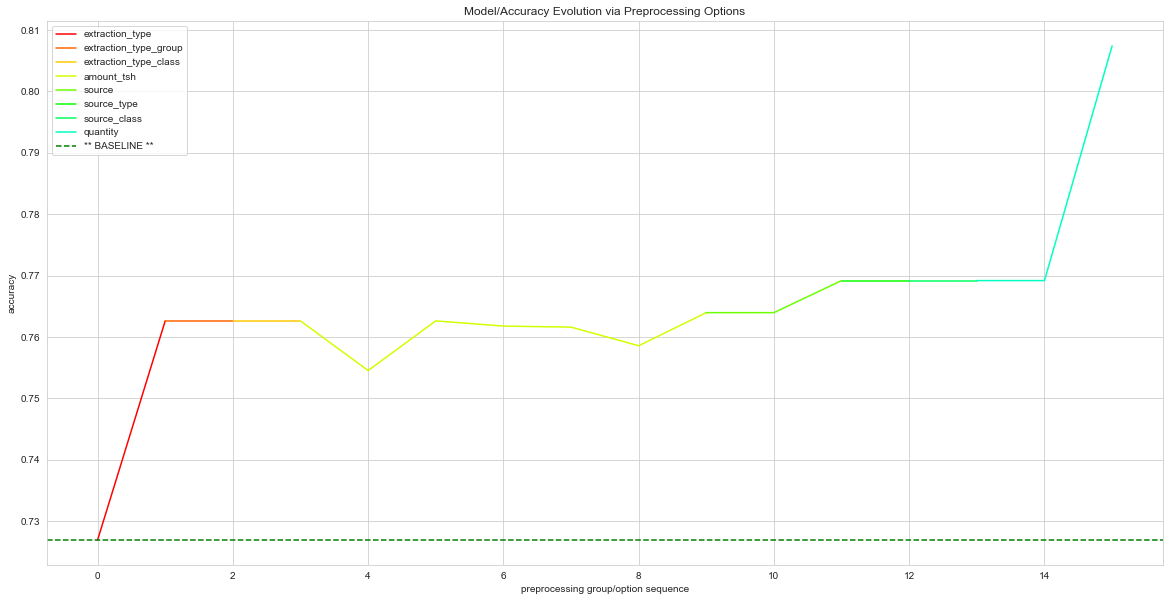

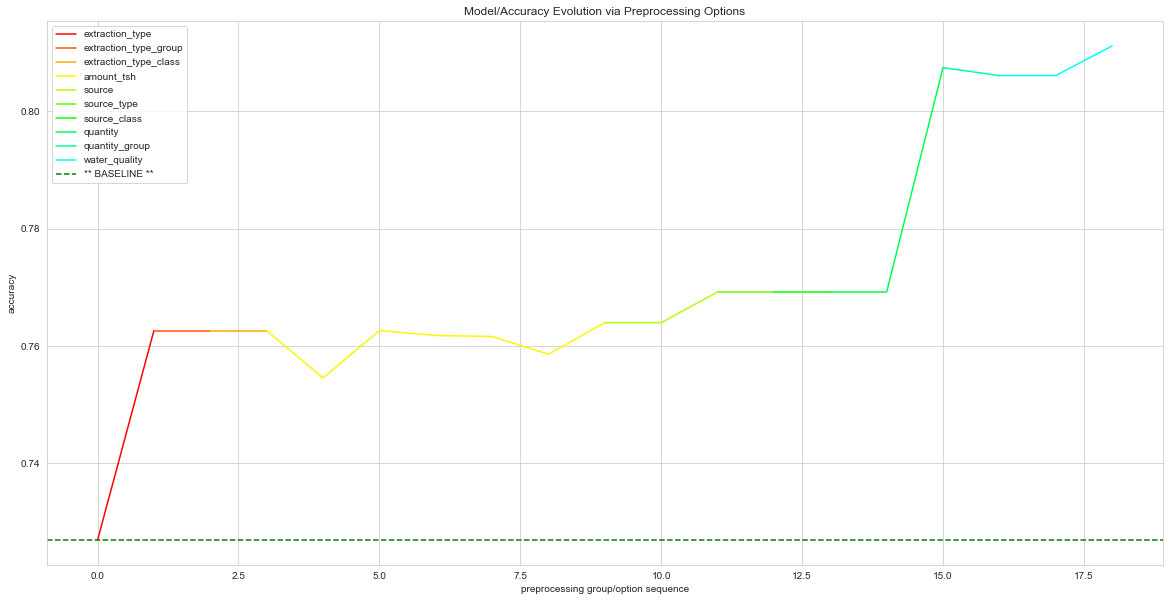

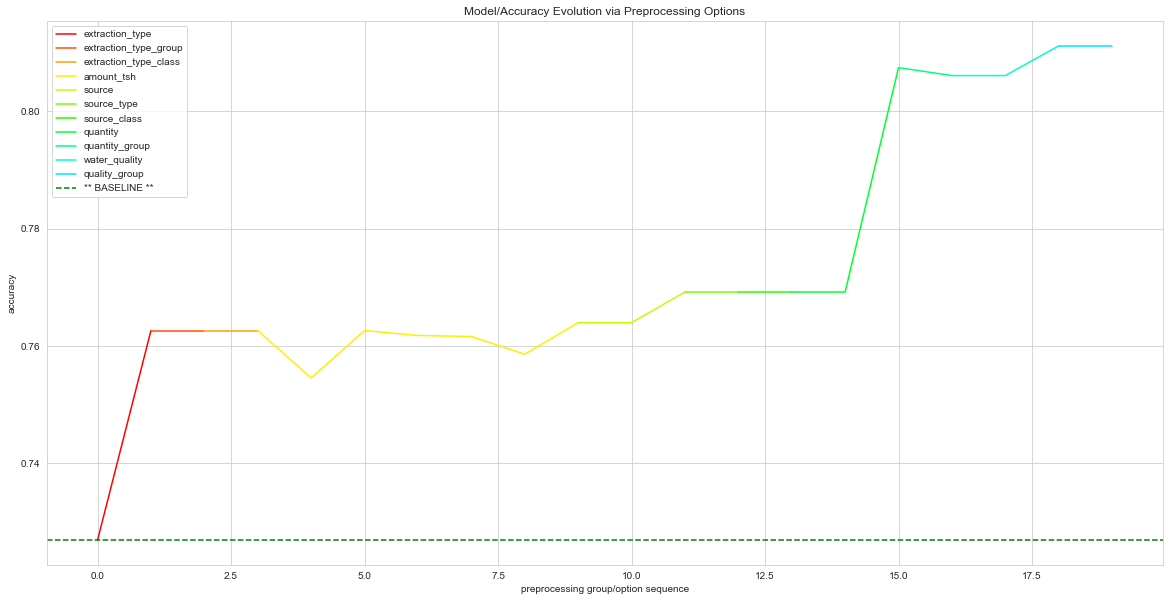

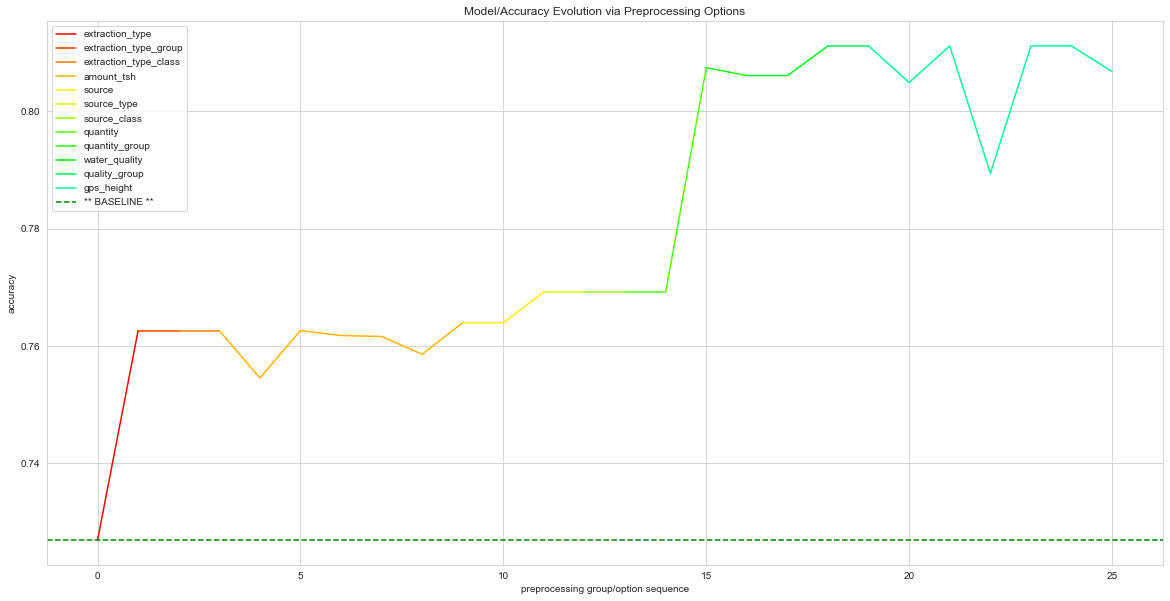

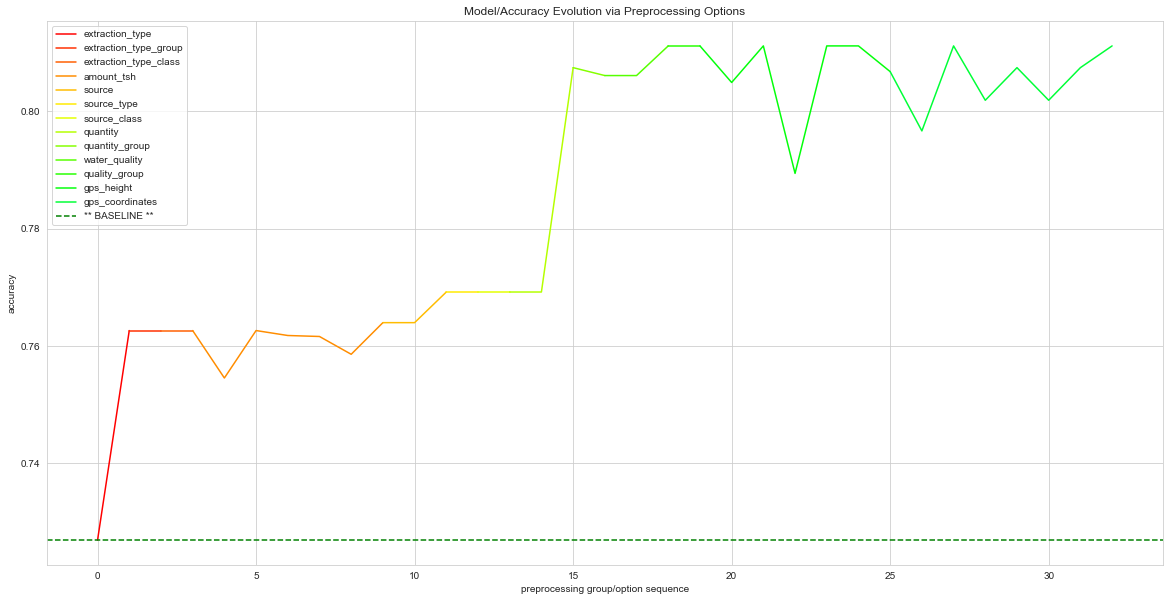

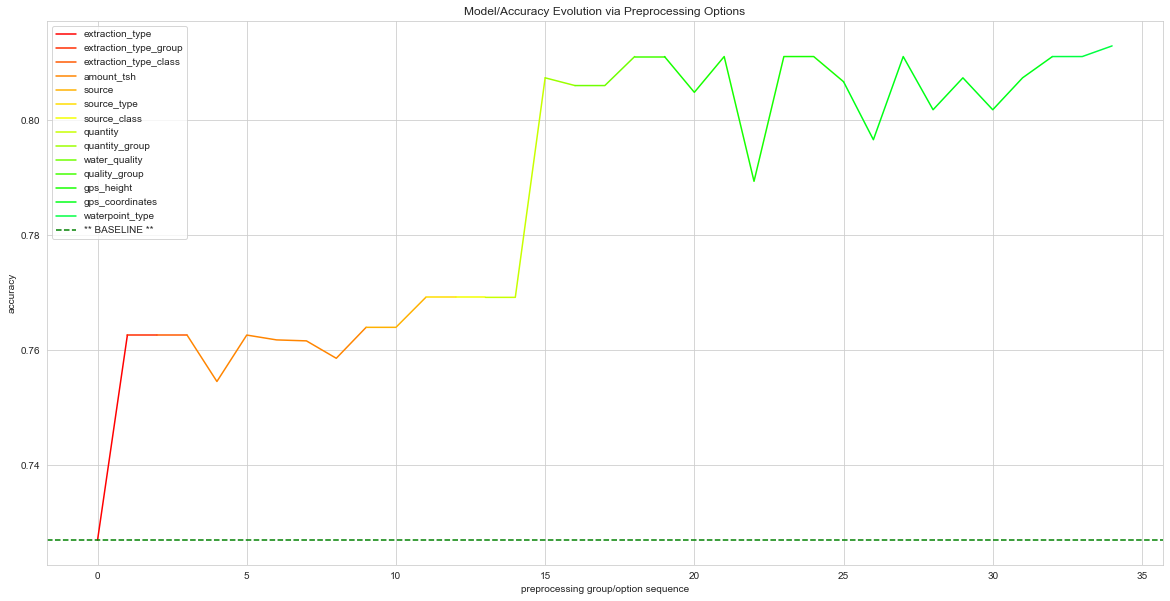

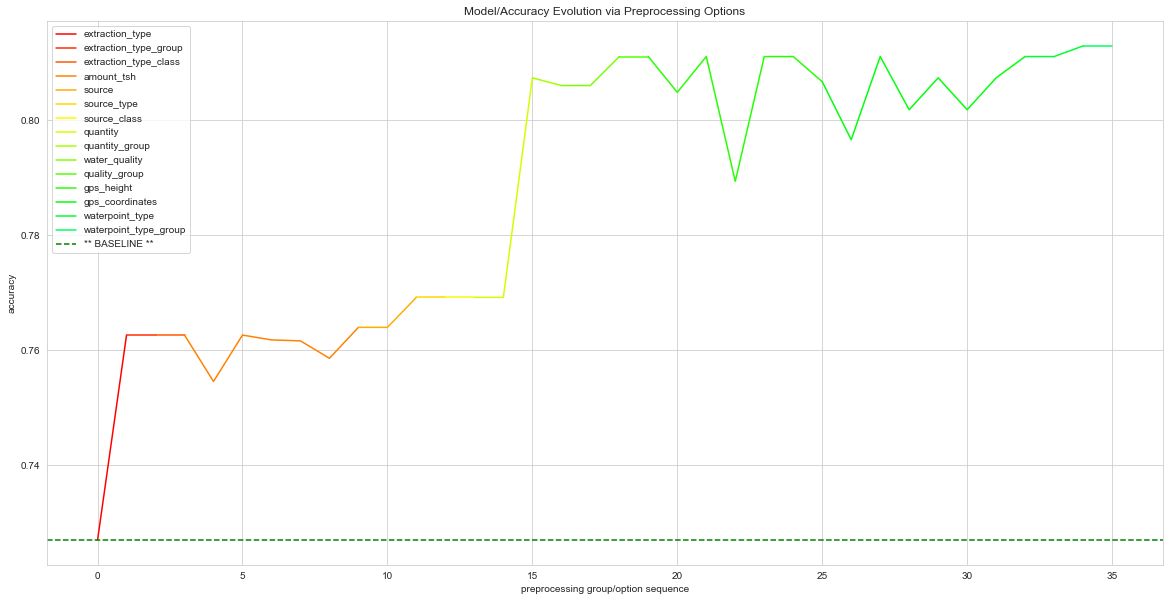

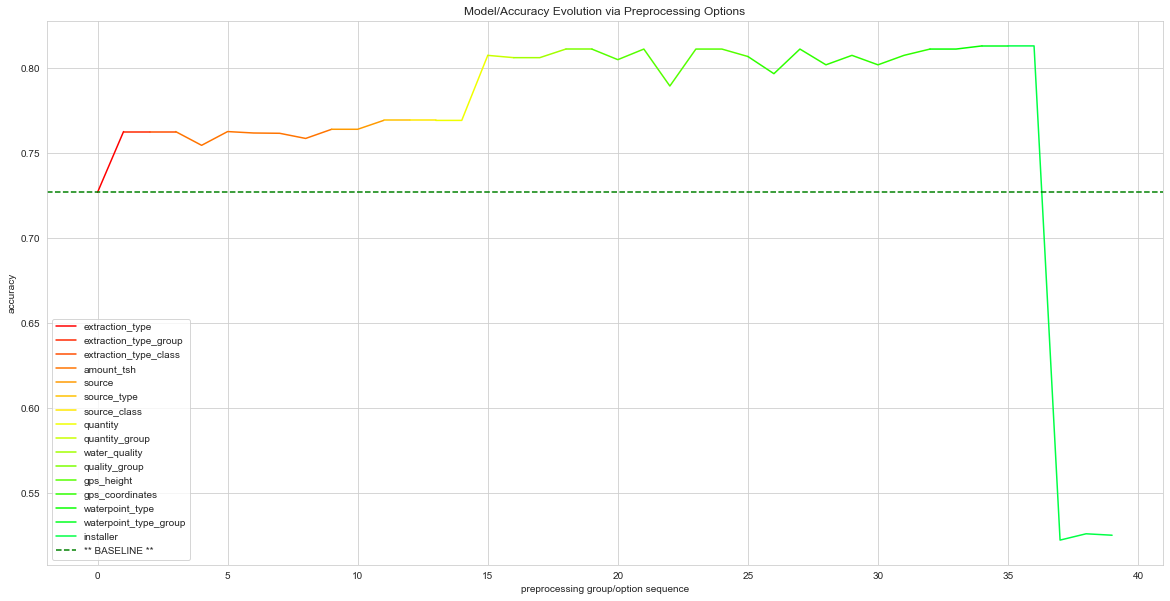

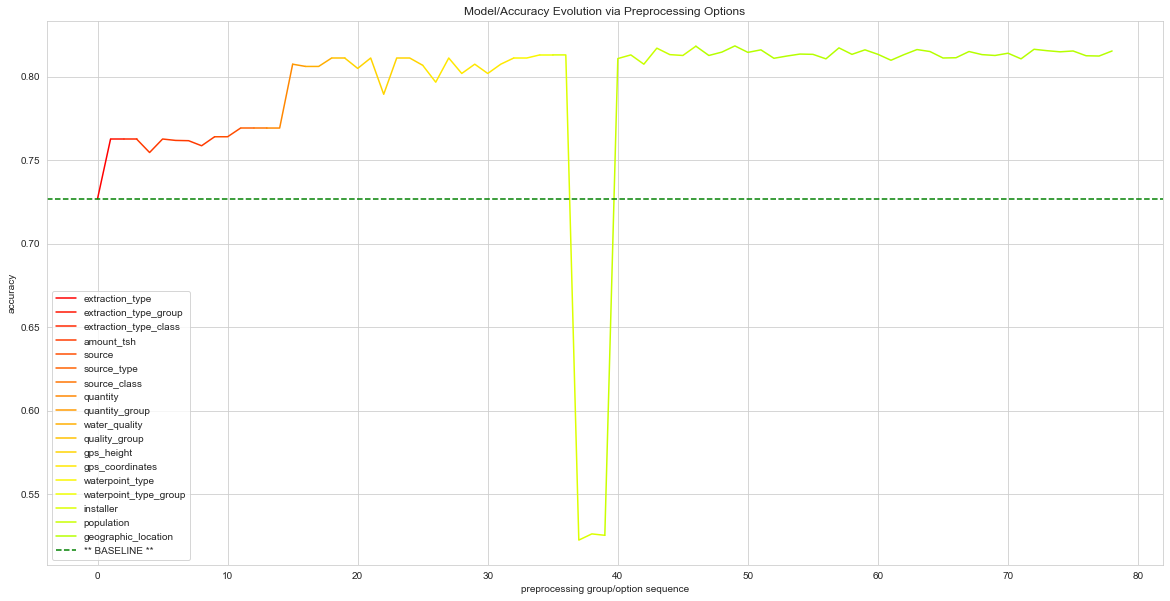

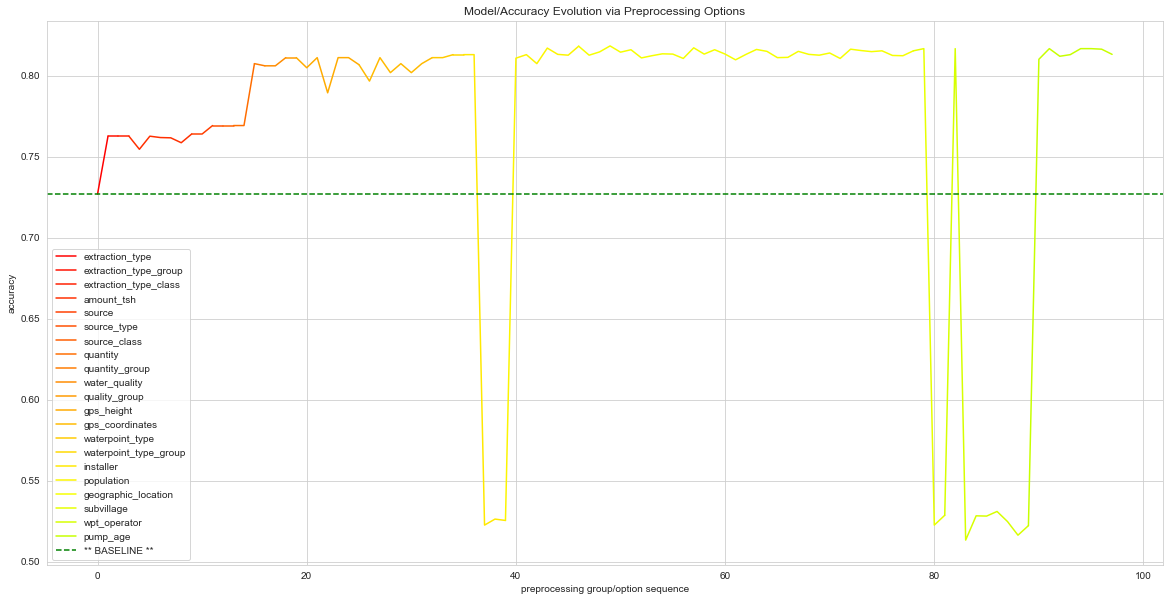

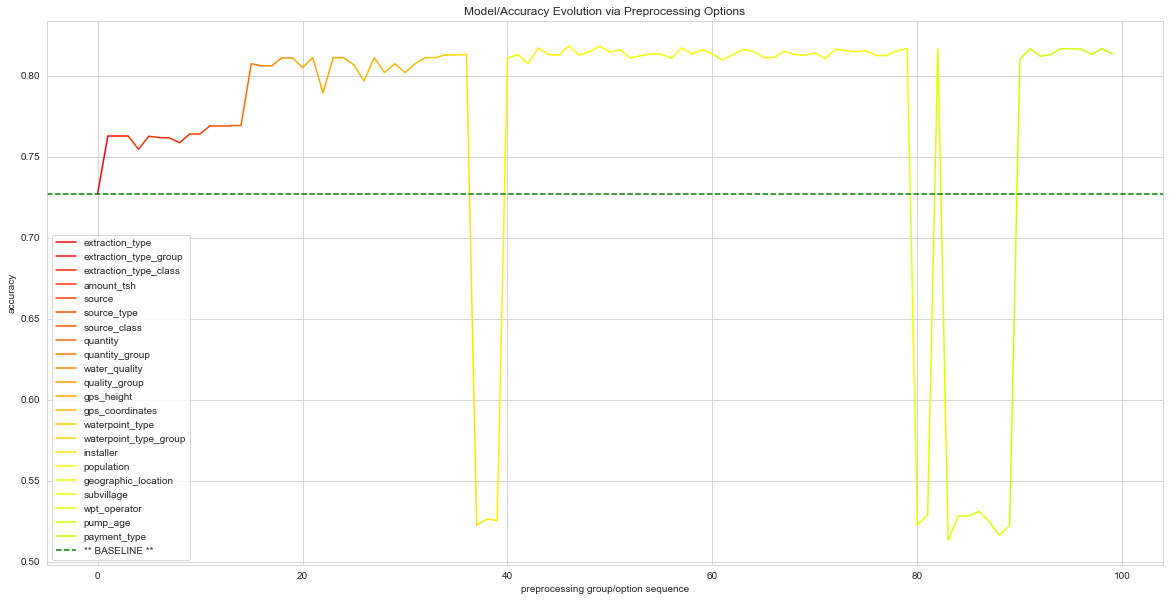

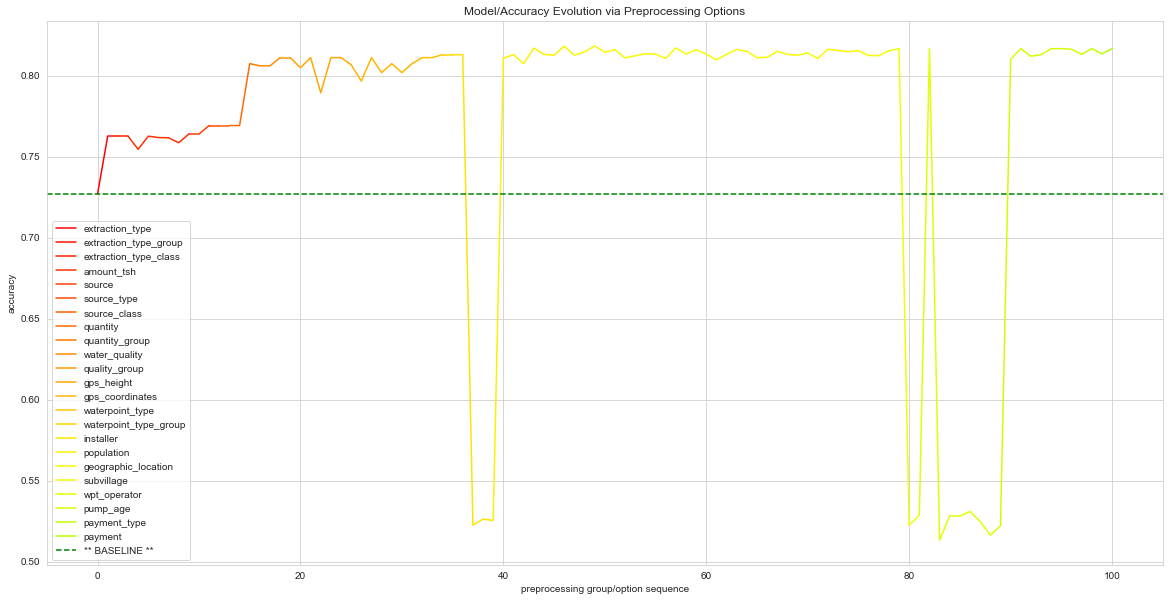

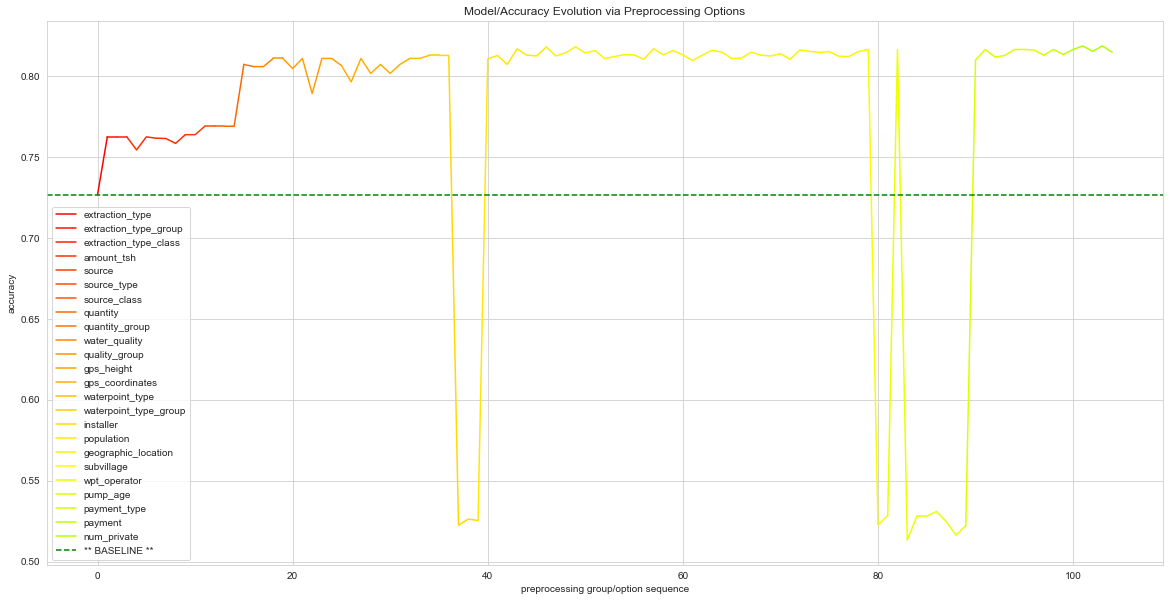

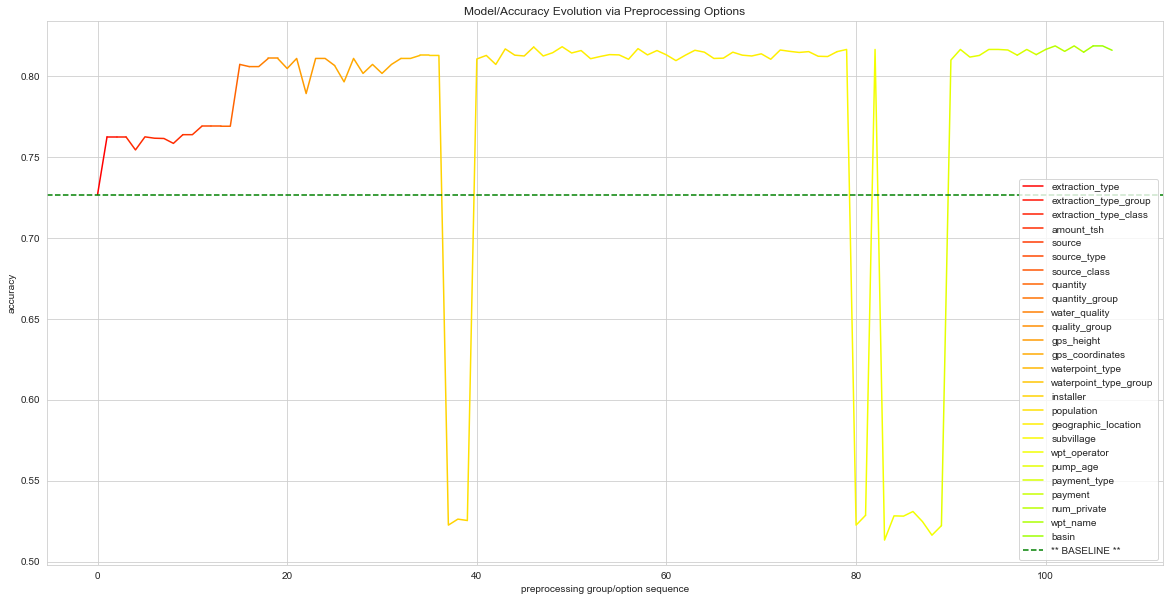

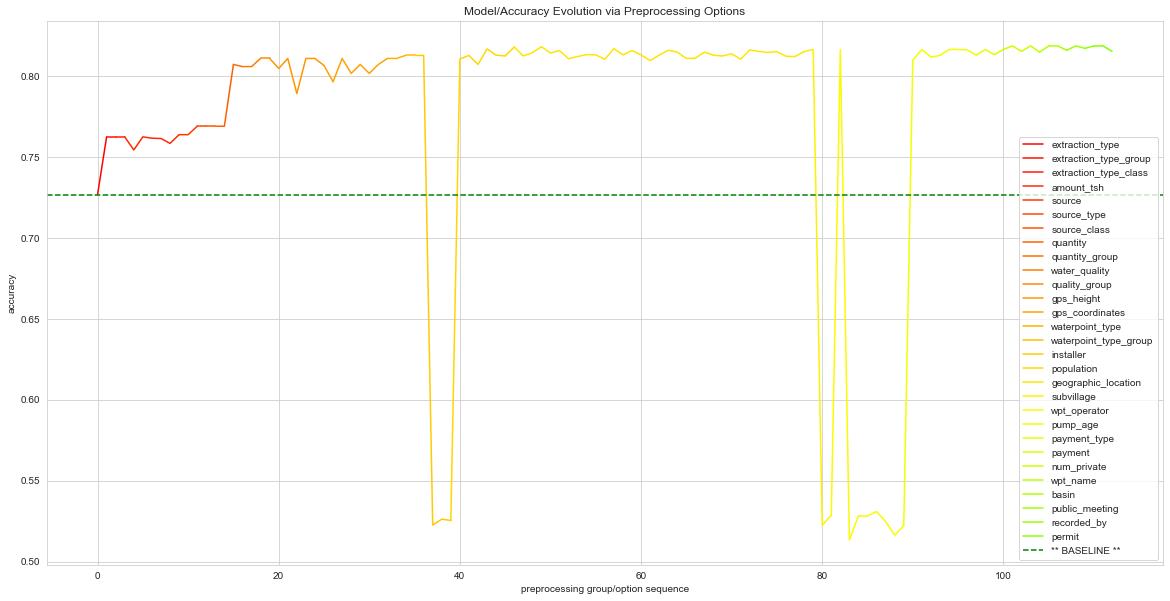

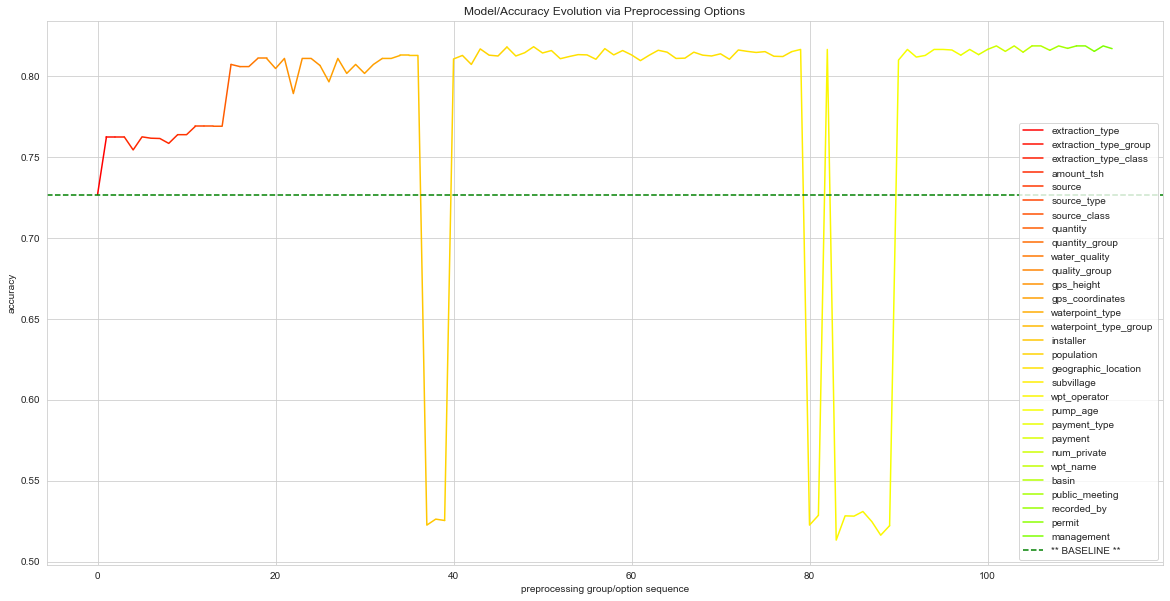

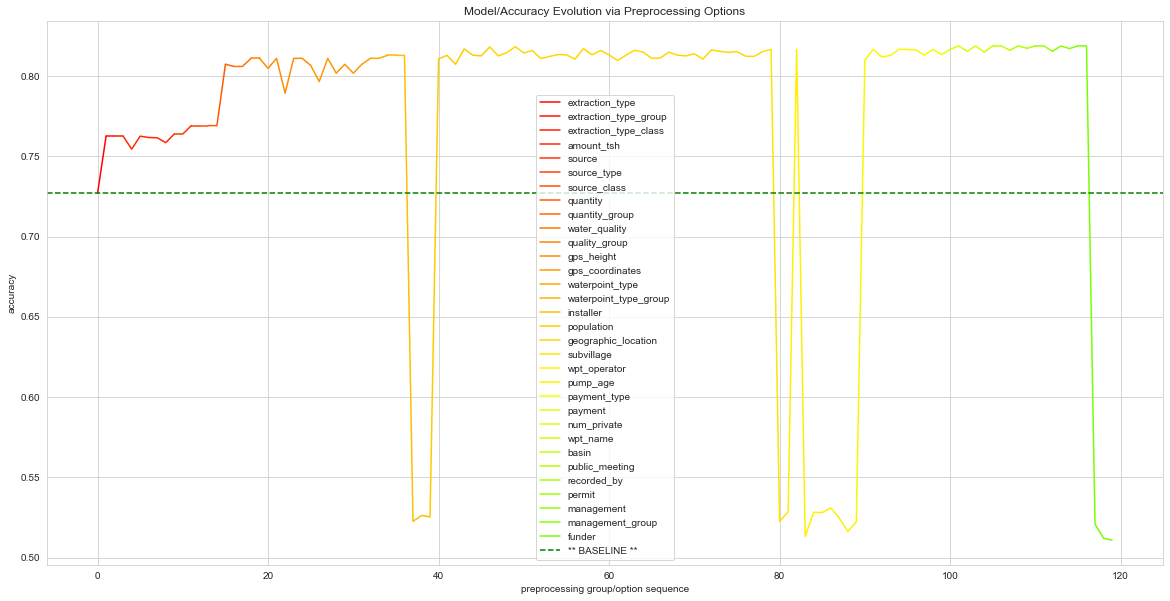

In [25]:
def get_cmap(n, name='hsv'):
    # from https://stackoverflow.com/a/25628397
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

best_options = []
y_acc = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']
    
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        best_option, y_acc = find_best_option(feat_group_name, preprocessing_group_name, best_options, y_acc)
        best_options.append(best_option)

        display(HTML("<p><br>"))
        plt.figure(figsize=(20,10))
        x_offset = 0
        cmap = get_cmap(sum(list(map(lambda y_acc_item: len(y_acc_item['acc']), y_acc))))
        for i, y_acc_item in enumerate(y_acc):
            xs = list(range(x_offset, x_offset+len(y_acc_item['acc'])))
            ys = y_acc_item['acc']
            if i > 0: # prepend acc of last item from last list so we don't have any discontinuity in plot
                xs = [x_offset-1] + xs
                ys = [y_acc[i-1]['acc'][-1]] + ys
            plt.plot(xs, ys, c=cmap(i), label=y_acc_item['ppgn'])
            x_offset += len(y_acc_item['acc'])
            
        plt.axhline(y=_accuracy_validation_baseline, linestyle='--', color="red" if best_option[3] < _accuracy_validation_baseline else "green", label='** BASELINE **')
        
        plt.xlabel('preprocessing group/option sequence')
        plt.ylabel('accuracy')
        plt.legend()
        plt.title('Model/Accuracy Evolution via Preprocessing Options')
        plt.show()

        display(HTML("<p><br><br><br><br>"))

## Test Best Preprocessing Options Transformations on `X_train`

In [26]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [27]:
X_train_preprocessed = X_train.copy()

for best_preprocessing_option in best_options:
    composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        best_preprocessing_option[1], 
        best_preprocessing_option[0],
        pipeline_data_preprocessor
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
    X_train_preprocessed = composite_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

In [28]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

## Save Transformed Training Data to CSV for Final Model Building

### Save Configuration First

In [29]:
best_preprocessing_config = {}

for best_preprocessing_option in best_options:
    best_preprocessing_config.update({best_preprocessing_option[0]: best_preprocessing_option[1]})

best_preprocessing_config

{'extraction_type': [['extraction_type',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'extraction_type_group': [['extraction_type_group',
   'C__drop_it__StrategyTransformer']],
 'extraction_type_class': [['extraction_type_class',
   'C__drop_it__StrategyTransformer']],
 'amount_tsh': [['amount_tsh', 'C__replace_0_with_nan__StrategyTransformer']],
 'source': [['source',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'source_type': [['source_type', 'C__drop_it__StrategyTransformer']],
 'source_class': [['source_class', 'C__drop_it__StrategyTransformer']],
 'quantity': [['quantity',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quantity_group': [['quantity_group', 'C__drop_it__StrategyTransformer']],
 'water_quality': [['water_quality',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quality_group': [['quality_group', 

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_validation`

In [30]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [31]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

In [32]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_unlabeled`

In [33]:
scjpnutils.analyze_values(X_unlabeled, 'X_unlabeled BEFORE preprocessing');

In [34]:
X_unlabeled_preprocessed = pipeline_data_preprocessor.transform(X_unlabeled)

In [35]:
scjpnutils.analyze_values(X_unlabeled_preprocessed, 'X_unlabeled AFTER preprocessing');

## Save Best Preprocessing Options (as Preprocessing Spec) to File

In [36]:
# used at the end of this process
if len(preprocessing_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = preprocessing_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(preprocessing_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = preprocessing_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

In [37]:
fname__best_options_cfg, fname__last_preprocessing_spec = scjpnutils.get_preprocessing_options_fname(preprocessing_config, best_preprocessing_config)
fname__best_options_cfg = WRANGLED_DATA_DIR + fname__best_options_cfg
fname__last_preprocessing_spec = WRANGLED_DATA_DIR + fname__last_preprocessing_spec
print(f"best preprocessing options config will be saved to: {fname__best_options_cfg}")
print(f"best preprocessing options config will be saved as last preprocessing spec to: {fname__last_preprocessing_spec}")

best preprocessing options config will be saved to: preprocessing-results/preprocessing-options-69feae104538a094014ae5cec62abdf0.json
best preprocessing options config will be saved as last preprocessing spec to: preprocessing-results/preprocessing-spec-last.json


In [38]:
fm.save_json(best_preprocessing_config, f"{fname__best_options_cfg}")
print(f"updated {fname__best_options_cfg}")

# also save canonical for model building
fm.save_json(best_preprocessing_config, f"{fname__last_preprocessing_spec}")
print(f"updated {fname__last_preprocessing_spec}")

updated preprocessing-results/preprocessing-options-69feae104538a094014ae5cec62abdf0.json
updated preprocessing-results/preprocessing-spec-last.json


# Conclusion

We're now ready to move on to the final model building stage.